# Proper and improper mixtures

**Proper mixture:** A (mixed) state that is the average of several independent states, realisations, trajectories, etc.

Examples:
- an ensemble of independent spin-1/2 systems in a medium
- multiple realisations of the same dynamics (trajectories)

**Improper mixture:** A (mixed) state that is the "local" description (*partial state*) of a subsystem in a composite system.

Examples:
- the partial state of a qubit that is entangled with another qubit
- the partial state of a system that interacts with an environment

## Import modules and packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Proper Mixture: Spin echo without decoherence

Consider a [spin echo](https://en.wikipedia.org/wiki/Spin_echo) experiment, where an ensemble of $N$ spins-1/2 systems precesses due to some magnetic field $\vec{B} = B_0 \hat{z}$ that has some Gaussian random fluctuations in its strength $B_0$, with mean $\mu = 0$ and standard deviation $\delta$.

At a certain time, $t_\pi$ a $\pi$-pulse $\sigma_x$ is applied to the spins, so they all flip.

Calculate the time-dependent expectation value $\langle x(t)\rangle = \mathrm{Tr}[\rho(t)\sigma_x]$ and purity $\mathcal{P}[\rho(t)] = \mathrm{Tr}[\rho^2(t)]$, where $\rho(t)$ is the mixture obtained as the overage over all the trajectories:

- $\rho(t) =  \sum_{k=1}^N \frac{1}{N}|\psi_k(t)\rangle\langle\psi_k(t)|$.

When looping over many trajectories, you can use the `progressbar` method from `tools`, which is based on `tqdm`.

Run a spin echo simulation with the following parameters:

- $|\psi_0\rangle = (|0\rangle +|1\rangle)/\sqrt{2}$
- $N$ = 50
- $B_0$ = 2
- $\delta$ = 0.8
- $t_\pi$ = 7
- $t_f$ = 50

measuring $O = \sigma_x$ as a function of time over the average state $\rho(t)$:

$\mathrm{Tr}[\rho(t)O] = \langle O(t)\rangle$.

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 224.16it/s]


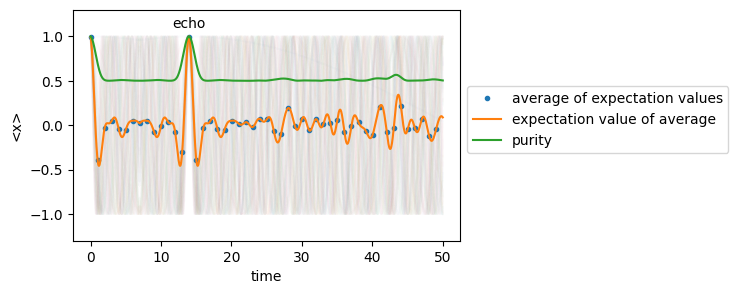

In [11]:
# import progress bar form tools
from tools import progressbar

# import matrix exponential
from scipy.linalg import expm

# function to get the Liouville superoperator
def liouvillian(H, c_ops = []):
    d = len(H) # dimension of the system
    superH = -1j * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in c_ops])
    return superH + superL

# propagation 
def prop(P,rho):
    # get system dimension
    dim = rho.shape[0]
    # propagate vectorise rho
    v = P @ np.reshape(rho,(dim*dim,1))
    # return density operator
    return np.reshape(v,(dim,dim))

# function to get the trajectories and the average state
def sampler(psi0, times, sample, O, d=0, t_pi = 0, T2 = np.inf):
    # time step
    dt = times[1]-times[0]
    # trajectories
    trajs = []
    # initial state
    rho0 = np.outer(psi0, psi0.conj().T)
    # initialise average state
    rho_t = np.array([0*rho0 for t in times])
    # iterate over trajectories
    for jj in progressbar(range(sample)):
        # Hamiltonian with normally distributed random field strength
        # centered on B0
        H = (B0+np.random.normal(0,d))*sigmaz/2
        # collapse operators
        c_ops = []
        # if decoherence is active
        if T2 != np.inf:
            # depolarisation decoherence model
            c_ops = [np.sqrt(1/T2)*sigmax,np.sqrt(1/T2)*sigmay,np.sqrt(1/T2)*sigmaz]
        # create propagator for small time step
        Pdt = expm(liouvillian(H,c_ops)*dt)
        #  ----  propagate ---- 
        # states array
        states = []
        # pi pulse
        gate = sigmax
        # initialise state
        rho = rho0
        # time at which the pulse is applied
        tpulse = times[np.searchsorted(times,t_pi)]
        # propagate
        for t in times:
            # apply the pulse
            if t == tpulse:
                rho = gate@rho@gate.conj().T
            # propagate state
            rho = prop(Pdt,rho)
            # append state
            states.append(rho)
        # measure x
        Os = np.array([np.real(np.trace(O @ state)) for state in states])
        # append to trajectory
        trajs.append(Os)
        # average the state
        rho_t = rho_t + np.array(states)
    # return trajectories
    return trajs, rho_t/sample

# downsample function to look only at a subset of points
def DS(x, N = 10):
    return x[::int(np.ceil( len(x) / N ))]

# random seed
np.random.seed(0)
    
# number of spins
sample = 50

# field strength
B0 = 2

# field standard deviation
d = 0.8

# pulse time
t_pi = 7

# pauli operators
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])

# operator to measure
O = sigmax

# initial state
psi0 = np.array([1,1])/np.sqrt(2)

# final time
tf = 50

# time domain
times = np.linspace(0,tf,1000)

# trajectories and average state
trajs, rho_t = sampler(psi0,times,sample,O,d=d,t_pi=t_pi)
        
# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
# plot independent trajectories
for xs in trajs:
    ax.plot(times, xs, alpha = 1/sample);
# plot average of trajectories
ax.plot(DS(times,50), DS(np.mean(trajs, axis=0),50),  '.', label = 'average of expectation values')
# plot expectation value of the average state (proper mixture)
ax.plot(times, np.array([np.real(np.trace(O @ state)) for state in rho_t]), label = 'expectation value of average')
# plot purity of the proper mixture
ax.plot(times, np.array([np.trace(state @ state) for state in rho_t]), label = 'purity')
ax.set_xlabel('time');
ax.set_ylabel('<x>');
ax.annotate('echo',(2*t_pi,1.1),ha='center')
ax.legend(bbox_to_anchor=(1., 0.7));
ax.set_ylim([-1.3,1.3]);

## Proper Mixture: Spin echo with decoherence

Repeat the above calculations consider an additional decoherence process given by the isotropic depolaristion noise generate by the Lindblad operators $\sigma_x,\sigma_y,\sigma_z$ at a rate $\gamma = 1/T_2$, using $T_2 = 200$.

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 219.59it/s]


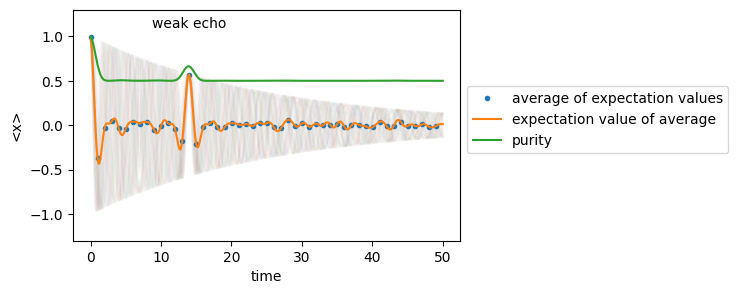

In [12]:
# random seed
np.random.seed(0)

# decoherence time
T2 = 100

# trajectories and average state
trajs, rho_t = sampler(psi0,times,sample,O,d=d,t_pi=t_pi,T2=T2)
        
# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
# plot independent trajectories
for xs in trajs:
    ax.plot(times, xs, alpha = 1/sample);
# plot average of trajectories
ax.plot(DS(times,50), DS(np.mean(trajs, axis=0),50),  '.', label = 'average of expectation values')
# plot expectation value of the average state (proper mixture)
ax.plot(times, np.array([np.real(np.trace(O @ state)) for state in rho_t]), label = 'expectation value of average')
# plot purity of the proper mixture
ax.plot(times, np.array([np.trace(state @ state) for state in rho_t]), label = 'purity')
ax.set_xlabel('time');
ax.set_ylabel('<x>');
ax.annotate('weak echo',(2*t_pi,1.1),ha='center')
ax.legend(bbox_to_anchor=(1., 0.7));
ax.set_ylim([-1.3,1.3]);

## Improper mixture: Interacting qubits

We now consider two initially uncorrelated qubits (product state) that evolve under the effect of some two-body interaction, such as $\sigma_x\otimes\sigma_x$, and look at the purity of the partial state of the system.

- Choose any local internal Hamiltonian $H_0 = H_0^{(1)}\otimes \mathbb{1} + \mathbb{1}\otimes H_0^{(2)}$
- Choose any interacting Hamiltonian, such as $H_1 = \sigma_x\otimes\sigma_y$, such that $[H_0,H_1]\neq 0$
- Choose any initial product state $|\psi_0\rangle = |\psi_0^{(1)}\rangle\otimes|\psi_0^{(2)}\rangle $
- Evolve the system and measure some observable $O(t)= \mathrm{Tr}[O\rho(t)]$ as a function of time
- Calculate the purity of a partial state as a function of time $\mathcal{P}[\mathrm{Tr}_2\rho(t)]$

Then, calculate the *[negativity](https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics))* (an entanglement measure) $\mathcal{N}[\rho(t)]$ as a function of time, where:

$\mathcal{N}[\rho] := \frac{1}{2}(||\rho^{T_1}||_1-1)$, where
-  $||X||_1 = \text{Tr}|X| = \text{Tr} \sqrt{X^\dagger X}$
-  $\rho^{T_1}$ is the partial transpose with respect to system 1.

**Note**: $\mathcal{N}=0$ for separable states, $\mathcal{N}>0$ for entangled states, $\mathcal{N}=0.5$ for maximally entangled 2-qubit states.

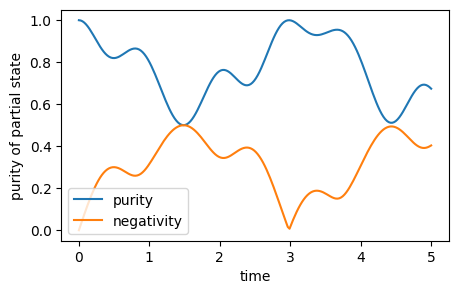

In [14]:
# internal Hamiltonian (local)
H0 = np.kron(sigmaz,np.eye(2))+np.kron(np.eye(2),sigmaz)

# interaction (two-body interaction)
H1 = np.kron(sigmax,sigmax)

# total Hamiltonian
H = H0 + H1

# local initial states
# subsystem A
psiA = np.array([1,1j])
# subsystem A density operator
rhoA = np.outer( psiA,psiA.conj().T )
# subsystem A normalised density operator
rhoA = rhoA/np.trace(rhoA)
# subsystem B density operator
rhoB = rhoA

# initial product state
rho0 = np.kron( rhoA, rhoB )

# unitary operator at time t
U = lambda t, H = H: expm(-1j * H * t)

# propagation
prop = lambda U,rho : U @ rho @ U.conj().T

# expectation value
expect = lambda operator,state : np.real(np.trace(operator @ state))

# purity
Purity = lambda state: np.real(np.trace(state@state))

# negativity
def Negativity(rho):
    # partial transpose
    pt = rho.reshape((2,2,2,2)).swapaxes(0,2).reshape((4,4))
    # eigenvalue
    ls,_ = np.linalg.eig(pt)
    return 0.5*np.sum([abs(l)-l for l in ls])

# partial trace of bipartite systems
def PartialTrace(rho,d1,d2,system=1):
    # define axes to be traced
    axis1,axis2 = 0,2
    # change axes if requested by system = 2
    if system == 2:
        axis1 += 1
        axis2 += 1
    # arrange and trace over chosen axes
    return np.trace(rho.reshape(d1,d2,d1,d2), axis1=axis1, axis2=axis2)

# ----- dynamics ------

t0,tf = 0,5                      # initial, final time
steps = 200                      # timesteps
times = np.linspace(t0,tf,steps) # time span
O = H0                           # observable to monitor

# collect propagated states
states = [prop(U(t),rho0) for t in times]

# measure the purity
purity = np.array([Purity(PartialTrace(state,2,2)) for state in states])

# measure the negativity
negativity = np.array([Negativity(state) for state in states])

# ----- plot ------
fig, ax = plt.subplots(figsize = (5,3))
ax.plot(times, purity, label = 'purity');
ax.plot(times, negativity, label = 'negativity');
ax.set_xlabel('time');
ax.set_ylabel('purity of partial state');
ax.legend();

### Bloch sphere representation

Any qubit density operator $\rho$ can be represented as a vector in a real 3D vector space $\vec{r} = (r_x,r_y,r_z)$ as:

$\rho =  \frac{\mathbb{1}+\vec{r}\cdot\vec{\sigma}}{2}$,

where $\vec{\sigma} = (\sigma_x,\sigma_y,\sigma_z)$ is a symbolic vector of Pauli operators. This is called the [Bloch representation](https://en.wikipedia.org/wiki/Bloch_sphere). The vector $\lVert\vec{r}\rVert \leq 1$ belongs to a ball of radius 1 called the Bloch ball, whose surface (the Bloch sphere) contains only pure states and whose interior contains only mixed states.

- Calculate the expectation value of all three Pauli operators $\sigma_x,\sigma_y,\sigma_z$
- Group the expecation values into the Bloch vector $\vec{r} = (r_x,r_y,r_z)$, with $r_k = \langle\sigma_k\rangle$.
- Represent the state on the Bloch-sphere (use `plt_sphere` from the `tools` library)

Represent the dynamics of one of the qubits on the Bloch sphere.

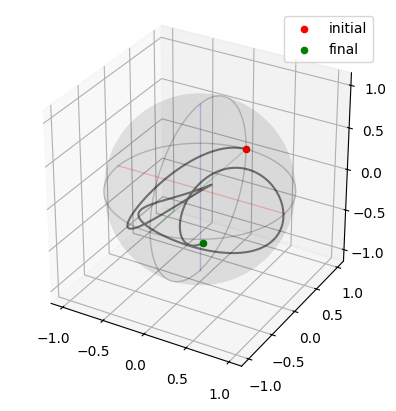

In [18]:
# import sphere tool
from tools import plt_sphere

# interactive plot 
interactive = False
if interactive:
    # use qt5 interactive backend
    %matplotlib qt5
else:
    # use inline backend
    %matplotlib inline

# vector of Pauli matricies
sigma = [sigmax,sigmay,sigmaz]

# function to get the bloch vector
bloch_vector = lambda rho: np.array([np.real(np.trace(s @ rho)) for s in sigma])

# Bloch sphere representation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_box_aspect([1,1,1])
plt_sphere(ax);

# get bloch vectors
rs = np.array([bloch_vector(PartialTrace(state,2,2)) for state in states])

# trajectory
ax.plot(*rs.T, c='k', alpha=0.5)                # trajectory on the bloch sphere
ax.scatter(*rs[0], c='r', label = 'initial')    # initial state
ax.scatter(*rs[-1], c='g',  label = 'final');   # final state
ax.legend();